### Import necessary libraries

In [39]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten,Merge,Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential,Model
#from sklearn.preprocessing import LabelEncoder,image
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
import numpy as np
from IPython.display import display 
from PIL import Image
import PIL.Image
import cv2
import numpy as np
import h5py

import geopatches
import time

In [77]:
#Choose the size of the tiles and extract as array using geopatches library
dict_img = {'width': 6, 'height': 6, 'stride': 6, 'padding': 3}
dict_label = {'width': 1, 'height': 1, 'stride': 1}
X_raw, Y_raw = geopatches.create_data(['1154314_2014-07-23_RE2_3A_Analytic_clipped.tif'],dict_img,\
                                    ['ClusterRaster10_LandCover.tif'],dict_label)
# Planetlabs needs to be divided by max uint16 = 65535 to be between 0 and 1.0
X_raw = X_raw / 65535

In [78]:
#remove classes that are too small
list_remove = []
for x in np.asarray(np.unique(Y_raw, return_counts=True)).T:
    if x[1] < 400:
        list_remove.append(x[0])
idx = np.arange(Y_raw.shape[0])[np.in1d(Y_raw,list_remove)]
X_raw = np.delete(X_raw,idx,0)
Y_raw = np.delete(Y_raw,idx,0)

In [79]:
X = X_raw

In [89]:
#Function to create npy files for each tile
def create_img_folder(X,Y_raw,train_index,test_index,val_index=None):
    count=0
    t=time.time()
    %cd data_custom/train
    for i in train_index:
        count=count+1
        np.save('RGB_'+str(i)+'.npy',X[i][:,:,:])
        if count%10000==0:
            print (time.time()-t)
            print (count)
            t=time.time()
    if val_index:
        %cd ..
        %cd validate
        for i in val_index:
            np.save('RGB_'+str(i)+'.npy',X[i][:,:,:])
    %cd ..
    %cd test
    count=0
    for i in test_index:
        np.save('RGB_'+str(i)+'.npy',X[i][:,:,:])

In [81]:
#Split the images into train, test and validate
sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
train_index, test_index = next(sss.split(X,Y_raw.flatten()))

X_train = X[train_index]
Y_train = Y_raw[train_index]

#train_index, val_index = next(sss.split(X_train,Y_train.flatten()))

X_test = X[test_index]
Y_test = Y_raw[test_index]

#X_val = X_train[val_index]
#Y_val = Y_train[val_index]

#X_train = X_train[train_index]
#Y_train = Y_train[train_index]

In [82]:
len(train_index)

123422

In [83]:
#Create dictionary to store train and test indexes
partition = {'train':train_index,'test':test_index}

In [84]:
#Get labels
labels = Y_raw.flatten()

In [12]:
!apt update && apt install -y libsm6 libxext6 libfontconfig1 libxrender1

Ign:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
Ign:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Get:3 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release [564 B]
Get:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release [564 B]
Get:5 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release.gpg [801 B]
Get:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release.gpg [801 B]
Get:7 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Packages [98.4 kB]
Get:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Packages [20.8 kB]
Get:9 http://archive.ubuntu.com/ubuntu xenial InRelease [247 kB]           
Get:10 http://ppa.launchpad.net/ubuntugis/ubuntugis-unstable/ubuntu xenial InRelease [23.8 kB]
Get

In [85]:
!pwd

/notebooks


In [87]:
%cd ../..

/notebooks


In [90]:
#Create images in respective folders
create_img_folder(X,Y_raw,train_index,test_index)

/notebooks/data_custom/train
2.058041572570801
10000
2.0400688648223877
20000
2.033390522003174
30000
2.1457667350769043
40000
2.1008222103118896
50000
2.094082832336426
60000
2.075732469558716
70000
2.0327062606811523
80000
2.043717384338379
90000
1.9963915348052979
100000
2.031646728515625
110000
2.0857222080230713
120000
/notebooks/data_custom
/notebooks/data_custom/test


In [92]:
#Assign each class a sequential value from 0 to n
classes={}
for i in range(len(set(labels))):
    classes[i]=list(set(labels))[i]

In [93]:
#Replace labels with new values
for i in range(len(labels)):
    labels[i]=(list(classes.keys())[list(classes.values()).index(labels[i])]) 

In [94]:
#Class to generate image batches to be fed to the model
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=128, dim=(216,216), n_channels=3,
                 n_classes=14, shuffle=True, sampletype='train'):
        #print(1)
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.sampletype = sampletype
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print(2)
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(3)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        #print(4)
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        #print(5)
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        #print(X.shape)
        y = np.empty((self.batch_size), dtype=int)
        #print (list_IDs_temp)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data_custom/'+self.sampletype+'/RGB_' + str(ID) + '.npy')
            #X1[i,] = np.load('data_custom/'+self.sampletype+'/NRR_' + str(ID) + '.npy')
            #print (i)
            #print ('ID:'+str(ID))
            #print ('label:'+str(self.labels[ID]))
            # Store class
            y[i] = self.labels[ID]
        #print (y[52])

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [95]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [96]:
# Parameters
params_train = {'dim': (12,12),
          'batch_size': 128,
          'n_classes': 11,
          'n_channels': 5,
          'shuffle': True,
          'sampletype':'train'}

params_test = {'dim': (12,12),
          'batch_size': 128,
          'n_classes': 11,
          'n_channels': 5,
          'shuffle': True,
          'sampletype':'test'}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params_train)
validation_generator = DataGenerator(partition['test'], labels, **params_test)

In [111]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(12, 12, 5)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))

#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(set(labels)), activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

#model.fit(x_train, y_train, batch_size=32, epochs=10)
#score = model.evaluate(x_test, y_test, batch_size=32)

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 10, 10, 32)        1472      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [112]:
from keras import optimizers

In [113]:
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

In [114]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics = ['accuracy'])

In [101]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [115]:
early_stopper = EarlyStopping(min_delta=0.001, patience=20)

In [116]:
# checkpoint
filepath="weights_cnn_custom_bn_11.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stopper]

In [117]:
!pwd

/notebooks


In [105]:
%cd ../..

/notebooks


In [118]:
model.input_shape

(None, 12, 12, 5)

In [120]:
from sklearn.utils import class_weight

In [122]:
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train.flatten()),
                                                 Y_train.flatten())

In [123]:
class_weight

array([ 5.61289736,  0.41571626,  0.61938624,  0.70306296,  3.24846028,
        9.12952141, 20.70144247,  0.25359782,  1.19135505, 11.72432792,
       21.78676081])

In [124]:
model.fit_generator(generator=training_generator,\
                    validation_data=validation_generator,\
                         use_multiprocessing=True,\
                         steps_per_epoch=X_train.shape[0] // 128,\
                        epochs=500,\
                         workers=6,\
                         callbacks=callbacks_list,\
                   class_weight=class_weight)

Epoch 1/500
964/964 [==============================] - 16s 16ms/step - loss: 1.7656 - acc: 0.4352 - val_loss: 1.4318 - val_acc: 0.5377

Epoch 00001: val_acc improved from -inf to 0.53770, saving model to weights_cnn_custom_bn_11.best.hdf5
Epoch 2/500
964/964 [==============================] - 14s 15ms/step - loss: 1.3819 - acc: 0.5366 - val_loss: 1.2685 - val_acc: 0.5796

Epoch 00002: val_acc improved from 0.53770 to 0.57955, saving model to weights_cnn_custom_bn_11.best.hdf5
Epoch 3/500
964/964 [==============================] - 14s 15ms/step - loss: 1.2797 - acc: 0.5559 - val_loss: 1.2036 - val_acc: 0.5847

Epoch 00003: val_acc improved from 0.57955 to 0.58467, saving model to weights_cnn_custom_bn_11.best.hdf5
Epoch 4/500
964/964 [==============================] - 14s 14ms/step - loss: 1.2267 - acc: 0.5680 - val_loss: 1.1545 - val_acc: 0.5937

Epoch 00004: val_acc improved from 0.58467 to 0.59365, saving model to weights_cnn_custom_bn_11.best.hdf5
Epoch 5/500
964/964 [==============

964/964 [==============================] - 14s 15ms/step - loss: 1.0711 - acc: 0.6054 - val_loss: 1.0621 - val_acc: 0.6148

Epoch 00041: val_acc did not improve from 0.62422
Epoch 42/500
964/964 [==============================] - 14s 15ms/step - loss: 1.0714 - acc: 0.6044 - val_loss: 1.0587 - val_acc: 0.6115

Epoch 00042: val_acc did not improve from 0.62422
Epoch 43/500
964/964 [==============================] - 14s 15ms/step - loss: 1.0703 - acc: 0.6066 - val_loss: 1.0820 - val_acc: 0.6026

Epoch 00043: val_acc did not improve from 0.62422
Epoch 44/500
964/964 [==============================] - 14s 14ms/step - loss: 1.0660 - acc: 0.6080 - val_loss: 1.0504 - val_acc: 0.6082

Epoch 00044: val_acc did not improve from 0.62422
Epoch 45/500
964/964 [==============================] - 14s 15ms/step - loss: 1.0692 - acc: 0.6066 - val_loss: 1.0385 - val_acc: 0.6207

Epoch 00045: val_acc did not improve from 0.62422
Epoch 46/500
964/964 [==============================] - 13s 14ms/step - loss: 

964/964 [==============================] - 14s 15ms/step - loss: 1.0414 - acc: 0.6137 - val_loss: 1.0079 - val_acc: 0.6309

Epoch 00084: val_acc improved from 0.62902 to 0.63093, saving model to weights_cnn_custom_bn_11.best.hdf5
Epoch 85/500
964/964 [==============================] - 14s 14ms/step - loss: 1.0399 - acc: 0.6148 - val_loss: 1.0259 - val_acc: 0.6238

Epoch 00085: val_acc did not improve from 0.63093
Epoch 86/500
964/964 [==============================] - 15s 15ms/step - loss: 1.0391 - acc: 0.6137 - val_loss: 1.0339 - val_acc: 0.6208

Epoch 00086: val_acc did not improve from 0.63093
Epoch 87/500
964/964 [==============================] - 14s 14ms/step - loss: 1.0386 - acc: 0.6143 - val_loss: 1.0089 - val_acc: 0.6298

Epoch 00087: val_acc did not improve from 0.63093
Epoch 88/500
964/964 [==============================] - 14s 15ms/step - loss: 1.0403 - acc: 0.6134 - val_loss: 1.0352 - val_acc: 0.6192

Epoch 00088: val_acc did not improve from 0.63093
Epoch 89/500
964/964 [

In [240]:
%cp train/* all_files/

/bin/sh: 1: cp: Argument list too long


In [243]:
%cd ..

/notebooks


In [264]:
X_raw.shape

(154880, 12, 12, 5)

In [125]:
# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [126]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    best_model = model_from_json(f.read())

# Load weights into the new model
best_model.load_weights('weights_cnn_custom_bn_11.best.hdf5')

In [127]:
best_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 10, 10, 32)        1472      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [131]:
overall_prob = np.ndarray(shape=(X_raw.shape[0],11))

In [132]:
for i in range(X_raw.shape[0]):
    overall_prob[i]=best_model.predict(np.expand_dims(X[i][:,:,:],axis=0))

In [281]:
overall_prob[300]

array([2.67879236e-02, 1.12848624e-03, 4.49445006e-03, 2.68102285e-05,
       1.52559311e-03, 7.46872649e-03, 1.52359474e-02, 3.18908423e-01,
       4.37978357e-01, 1.66027069e-01, 4.51146625e-03, 4.08999808e-03,
       1.02688037e-02, 1.54791167e-03])

In [133]:
y_pred=[]
for i in range(X_raw.shape[0]):
    y_pred.append(overall_prob[i].argsort()[-1:][::-1])

In [134]:
len(y_pred)

154278

In [135]:
len(labels.tolist())

154278

In [136]:
import pandas as pd

In [137]:
from sklearn.metrics import confusion_matrix

In [138]:
df = pd.DataFrame(confusion_matrix(labels.tolist(), y_pred),columns = classes.values(),index=classes.values())

In [139]:
df

,71,43,11,82,52,21,22,23,24,90,31
71,644,0,3,18,5804,4518,467,286,32,0,1
43,1,0,1,0,363,295,16,1,0,0,0
11,1,0,2335,0,76,63,9,15,0,0,0
82,92,0,0,117,485,412,23,50,16,0,1
52,100,0,40,22,51738,3045,237,119,4,0,0
21,460,0,275,67,9831,17509,4224,1321,50,0,1
22,102,0,137,0,1632,8838,7815,4066,54,0,0
23,18,0,59,0,167,1102,2798,15102,701,0,2
24,10,0,21,0,17,78,45,2520,1626,0,1
90,3,0,7,0,387,244,1,1,0,0,0


In [140]:
y_p = []
for i in range(len(y_pred)):
    y_p.append(y_pred[i][0])

In [141]:
from sklearn.metrics import classification_report

In [142]:
print(classification_report(labels.tolist(),y_p))

             precision    recall  f1-score   support

          0       0.40      0.05      0.10     11773
          1       0.00      0.00      0.00       677
          2       0.81      0.93      0.87      2499
          3       0.52      0.10      0.16      1196
          4       0.73      0.94      0.82     55305
          5       0.48      0.52      0.50     33738
          6       0.50      0.35      0.41     22644
          7       0.64      0.76      0.69     19949
          8       0.65      0.38      0.48      4318
          9       0.00      0.00      0.00       643
         10       0.00      0.00      0.00      1536

avg / total       0.59      0.63      0.59    154278



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [311]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

In [303]:
import seaborn as sns

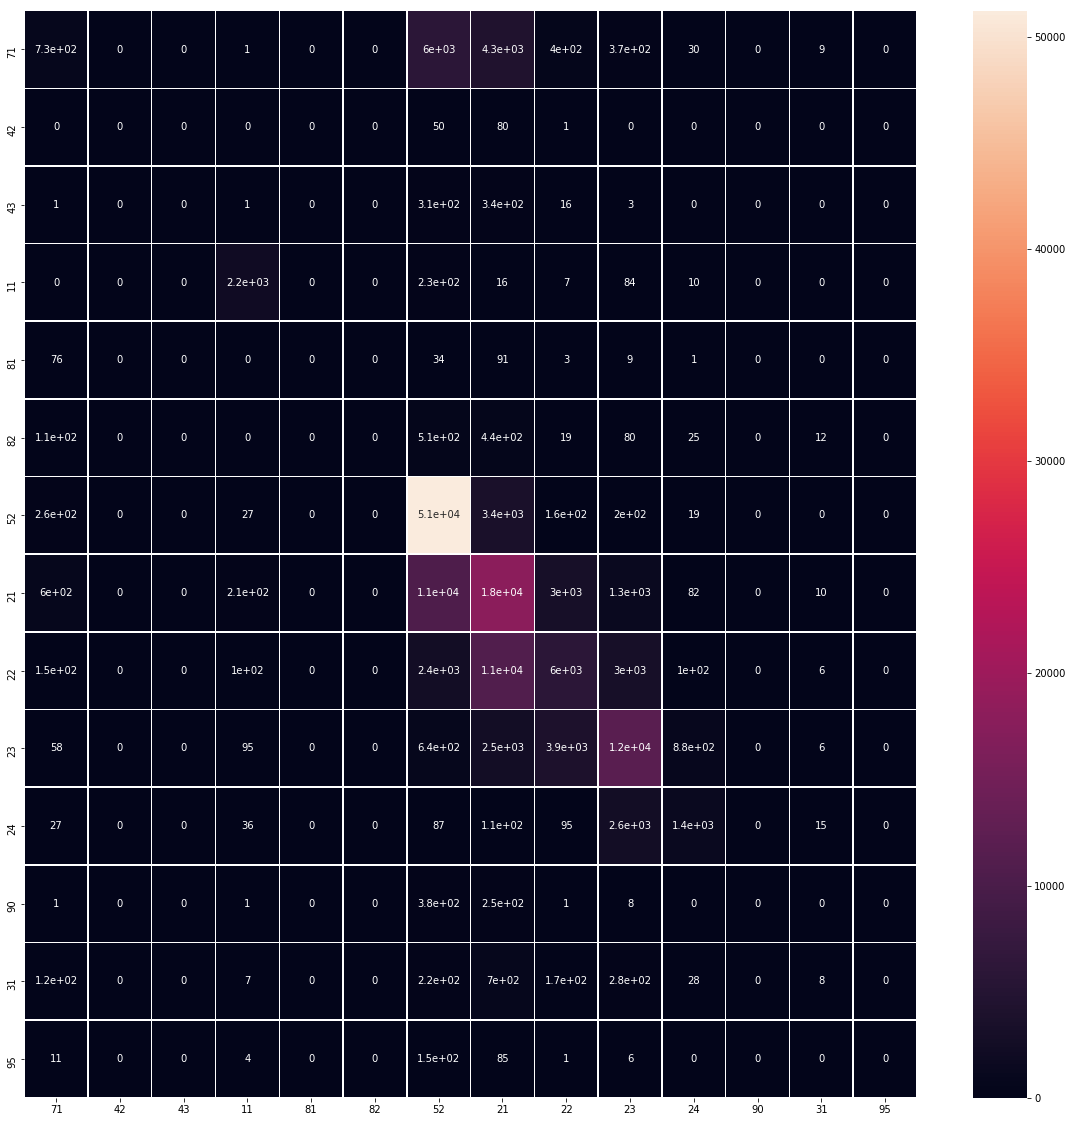

In [314]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(df, annot=True, linewidths=.5, ax=ax)

In [6]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 36s 0us/step


In [7]:
X_train1 = np.ndarray(shape=(10000,197,197,3))
for i in range(10000):
    X_train1[i]=cv2.resize(X_train[i][:,:,:], dsize=(197, 197), interpolation=cv2.INTER_LANCZOS4)

In [8]:
X_test.shape

(10000, 32, 32, 3)

In [9]:
X_test1 = np.ndarray(shape=(1000,197,197,3))
for i in range(1000):
    X_test1[i]=cv2.resize(X_test[i][:,:,:], dsize=(197, 197), interpolation=cv2.INTER_LANCZOS4)

In [11]:
from keras.utils import np_utils

In [12]:
nb_classes = 10

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train1.astype('float32')
X_test = X_test1.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [14]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

In [15]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

In [19]:
Y_test[:1000].shape

(1000, 10)

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

train_generator = datagen.flow(X_train,Y_train[:10000],batch_size=64)
test_generator = datagen.flow(X_test,Y_test[:1000],batch_size=64)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [86]:
type(train_generator)

keras.preprocessing.image.NumpyArrayIterator

In [75]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_6NRR (InputLayer)         (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_padNRR (ZeroPadding2D)    (None, 203, 203, 3)  0           input_6NRR[0][0]                 
__________________________________________________________________________________________________
conv1 (Con

In [124]:
model_RGB = ResNet50(weights='imagenet', include_top=False, input_shape=(197,197,3))

for layer in model_RGB.layers:
    layer.trainable = False
    
x = Dense(2048, activation='relu')(model_RGB.output)
predictions = Dense(10, activation='softmax')(x)

final_model = Model(inputs=model_RGB.input, outputs=predictions)

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

final_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics = ['accuracy'])

In [125]:
final_model.fit(X_train, np.expand_dims(np.expand_dims(Y_train[:10000],axis=1),axis=1),
              batch_size=32,
              epochs=10,
              validation_data=(X_test, np.expand_dims(np.expand_dims(Y_test[:1000],axis=1),axis=1)),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 41s 4ms/step - loss: 2.0125 - acc: 0.3267 - val_loss: 2.4706 - val_acc: 0.0980
Epoch 2/10
10000/10000 [==============================] - 31s 3ms/step - loss: 1.4790 - acc: 0.5968 - val_loss: 2.5927 - val_acc: 0.1030
Epoch 3/10
10000/10000 [==============================] - 30s 3ms/step - loss: 1.2071 - acc: 0.6715 - val_loss: 2.6795 - val_acc: 0.1030
Epoch 4/10
10000/10000 [==============================] - 30s 3ms/step - loss: 1.0563 - acc: 0.7019 - val_loss: 2.8048 - val_acc: 0.1030
Epoch 5/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.9579 - acc: 0.7226 - val_loss: 2.8559 - val_acc: 0.1030
Epoch 6/10
 5024/10000 [==============>...............] - ETA: 13s - loss: 0.9013 - acc: 0.7337

KeyboardInterrupt: 

In [78]:
    # Fit the model on the batches generated by datagen.flow().
final_model.fit_generator(([X_train,X_train],np.expand_dims(np.expand_dims(Y_train[:10000],axis=1),axis=1)),
                        steps_per_epoch=100,
                        validation_data=([X_test,X_test],np.expand_dims(np.expand_dims(Y_test[:1000],axis=1),axis=1)),
                        epochs=50, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper])

Epoch 1/50


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(([array([[..., epochs=50, verbose=1, callbacks=[<keras.ca..., max_queue_size=100, validation_data=([array([[..., steps_per_epoch=100)`
  


TypeError: 'tuple' object is not an iterator

In [14]:
X_train1 = np.ndarray(shape=((15488, 216, 216, 3)))
for i in range(0,15488):
    X_train1[i]=cv2.resize(X_train[i][:,:,:3], dsize=(216, 216), interpolation=cv2.INTER_NEAREST)

In [33]:
# Variables
batch_size = 128
nb_epoch = 50
steps_per_epoch = 100
window_size = X_train1.shape[1]
nb_classes = Y_train.shape[1]
nb_channels = X_train1.shape[3]

In [15]:
X_test1 = np.ndarray(shape=((1548, 216, 216, 3)))
for i in range(0,1548):
    X_test1[i]=cv2.resize(X_test[i][:,:,:3], dsize=(216, 216), interpolation=cv2.INTER_NEAREST)

In [16]:
Y_test=np.expand_dims(np.expand_dims(Y_test,axis=1),axis=1)

In [35]:
Y_test[:1548].shape

(1548, 1, 1, 14)

In [25]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 216, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 222, 222, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 108, 108, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 108, 108, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [40]:
acc = final_model.evaluate(X_test1, Y_test[:1548], verbose=0)

In [41]:
acc

2.4777791537055673

In [47]:
np.expand_dims(X_test1[1244],axis=0).shape

(1, 216, 216, 3)

In [49]:
Y_test[1244].shape

(1, 1, 14)

In [54]:
final_model.predict(np.expand_dims(X_test1[1246],axis=0))

array([[[[0.1340938 , 0.08060184, 0.06358925, 0.10319147, 0.04658259,
          0.05314061, 0.06460004, 0.02945529, 0.10833786, 0.04490286,
          0.08699969, 0.06189188, 0.0402847 , 0.08232816]]]],
      dtype=float32)

In [55]:
Y_test[1246]

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

In [96]:
len(labels[train_index])

99123

In [97]:
len(train_index)

99123

In [101]:
for i in train_index:
    if i == 117552:
        print (1)

1


In [138]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
from keras.applications.vgg16 import VGG16


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')

batch_size = 32
nb_classes = 10
nb_epoch = 200
data_augmentation = False

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

X_train1 = np.ndarray(shape=(50000,48,48,3))
for i in range(50000):
    X_train1[i]=cv2.resize(X_train[i][:,:,:], dsize=(48, 48), interpolation=cv2.INTER_LANCZOS4)

X_test1 = np.ndarray(shape=((10000, 48, 48, 3)))
for i in range(10000):
    X_test1[i]=cv2.resize(X_test[i][:,:,:3], dsize=(48, 48), interpolation=cv2.INTER_NEAREST)

X_train = X_train1
X_test = X_test1

    
#model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
#for layer in model.layers:
#    layer.trainable = False
    
#x = Dense(512, activation='relu')(model.output)
#predictions = Dense(10, activation='softmax')(x)

#model = Model(inputs=model.input, outputs=predictions)

#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

model_RGB = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
model_NRR = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

for layer in model_NRR.layers:
    layer.name = layer.name + str("NRR")

for layer in model_RGB.layers:
    layer.trainable = False
for layer in model_NRR.layers:
    layer.trainable = False

combineFeatureLayer = keras.layers.concatenate([model_RGB.output, model_NRR.output])
x = Dense(1024, activation='relu')(combineFeatureLayer)
predictions = Dense(10, activation='softmax')(x)

final_model = Model(inputs=[model_RGB.input,model_NRR.input], outputs=predictions)

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

final_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics = ['accuracy'])


if not data_augmentation:
    print('Not using data augmentation.')
    final_model.fit([X_train,X_train], np.expand_dims(np.expand_dims(Y_train,axis=1),axis=1),
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=([X_test,X_test], np.expand_dims(np.expand_dims(Y_test,axis=1),axis=1)),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, np.expand_dims(np.expand_dims(Y_train,axis=1),axis=1), batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, np.expand_dims(np.expand_dims(Y_test,axis=1),axis=1)),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:96: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


50000/50000 [==============================] - 56s 1ms/step - loss: 1.8310 - acc: 0.4033 - val_loss: 1.5878 - val_acc: 0.4911
Epoch 2/200
50000/50000 [==============================] - 46s 911us/step - loss: 1.4524 - acc: 0.5238 - val_loss: 1.4303 - val_acc: 0.5100
Epoch 3/200
50000/50000 [==============================] - 46s 912us/step - loss: 1.3211 - acc: 0.5594 - val_loss: 1.3327 - val_acc: 0.5523
Epoch 4/200
50000/50000 [==============================] - 46s 913us/step - loss: 1.2483 - acc: 0.5783 - val_loss: 1.2918 - val_acc: 0.5545
Epoch 5/200
50000/50000 [==============================] - 46s 915us/step - loss: 1.1996 - acc: 0.5946 - val_loss: 1.2544 - val_acc: 0.5705
Epoch 6/200
50000/50000 [==============================] - 46s 915us/step - loss: 1.1640 - acc: 0.6057 - val_loss: 1.2318 - val_acc: 0.5755
Epoch 7/200
50000/50000 [==============================] - 46s 914us/step - loss: 1.1364 - acc: 0.6135 - val_loss: 1.2085 - val_acc: 0.5819
Epoch 8/200
50000/50000 [=========

KeyboardInterrupt: 